In [65]:
import os
import torch
import json
import h5py
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw
import cv2 

from matplotlib import pyplot as plt

In [3]:
image_file = json.load(open('../datasets/vg/image_data.json'))
vocab_file = json.load(open('../datasets/vg/VG-SGG-dicts-with-attri.json'))
data_file = h5py.File('../datasets/vg/VG-SGG-with-attri.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [4]:
# load detected results
path = '../checkpoints/iba0.02_s2_inv_prop0.03_power0.5_sum_v3-predcls/'
detected_origin_path = path + 'inference/VG_stanford_filtered_with_attribute_test/'
dir_fmap = path + '/rib/'

In [5]:
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [17]:
def get_union(box1, box2): 
    ubox = [0, 0, 0, 0]
    
    ubox[0] = min(box1[0], box2[0])
    ubox[1] = min(box1[1], box2[1])
    ubox[2] = max(box1[2], box2[2])
    ubox[3] = max(box1[3], box2[3])
    return ubox

In [6]:
# get image info by index
def get_info_by_idx(idx, det_input, thres=0.5):
    groundtruth = det_input['groundtruths'][idx]
    prediction = det_input['predictions'][idx]
    # image path
    img_path = detected_info[idx]['img_file']
    # boxes
    boxes = groundtruth.bbox
    
    # object labels
    idx2label = vocab_file['idx_to_label']
    labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(groundtruth.get_field('labels').tolist())]
    pred_labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(prediction.get_field('pred_labels').tolist())]
    
    # groundtruth relation triplet
    idx2pred = vocab_file['idx_to_predicate']
    gt_rels = groundtruth.get_field('relation_tuple').tolist()
    gt_rels = [(labels[i[0]], idx2pred[str(i[2])], labels[i[1]]) for i in gt_rels]
    
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_scores')
    pred_rel_label[:,0] = 0
    pred_rel_score, pred_rel_label = pred_rel_label.max(-1)
    
    #mask = pred_rel_score > thres
    #pred_rel_score = pred_rel_score[mask]
    #pred_rel_label = pred_rel_label[mask]
    pred_rels = [(pred_labels[i[0]], idx2pred[str(j)], pred_labels[i[1]]) for i, j in zip(pred_rel_pair, pred_rel_label.tolist())]
    return img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label

In [59]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+60, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)
        
def draw_union_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y2), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y2), (x1+160, y2+10)), fill=color)
        info = draw_info
        draw.text((x1 + 5, y2), info)

def print_list(name, input_list):
    for i, item in enumerate(input_list):
        print(name + ' ' + str(i) + ': ' + str(item))
    
def draw_image(img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label, print_img=True):
    pic = Image.open(img_path)
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        info = labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    if print_img:
        display(pic)
    if print_img:
        print('*' * 50)
        print_list('gt_boxes', labels)
        print('*' * 50)
        print_list('gt_rels', gt_rels)
        print('*' * 50)
    print_list('pred_rels', pred_rels[:20])
    print('*' * 50)
    
    return None

In [73]:
gt_path = './gt_boxes/'
os.mkdir(gt_path)

./gt_boxes/2343729_0.pdf
./gt_boxes/2343729_1.pdf
./gt_boxes/2343729_2.pdf
./gt_boxes/2343729_3.pdf
./gt_boxes/2343729_4.pdf
./gt_boxes/2343728_0.pdf
./gt_boxes/2343728_1.pdf
./gt_boxes/2343728_2.pdf
./gt_boxes/2343728_3.pdf
./gt_boxes/2343727_0.pdf
./gt_boxes/2343727_1.pdf
./gt_boxes/2343726_0.pdf
./gt_boxes/2343726_1.pdf
./gt_boxes/2343726_2.pdf
./gt_boxes/2343726_3.pdf
./gt_boxes/2343726_4.pdf
./gt_boxes/2343725_0.pdf
./gt_boxes/2343725_1.pdf
./gt_boxes/2343724_0.pdf
./gt_boxes/2343724_1.pdf
./gt_boxes/2343723_0.pdf
./gt_boxes/2343723_1.pdf
./gt_boxes/2343723_2.pdf
./gt_boxes/2343723_3.pdf
./gt_boxes/2343723_4.pdf
./gt_boxes/2343723_5.pdf
./gt_boxes/2343723_6.pdf
./gt_boxes/2343723_7.pdf
./gt_boxes/2343723_8.pdf
./gt_boxes/2343722_0.pdf
./gt_boxes/2343722_1.pdf
./gt_boxes/2343722_2.pdf
./gt_boxes/2343722_3.pdf
./gt_boxes/2343722_4.pdf
./gt_boxes/2343722_5.pdf
./gt_boxes/2343722_6.pdf
./gt_boxes/2343722_7.pdf
./gt_boxes/2343722_8.pdf
./gt_boxes/2343722_9.pdf
./gt_boxes/2343721_0.pdf


./gt_boxes/2343680_29.pdf
./gt_boxes/2343680_30.pdf
./gt_boxes/2343680_31.pdf
./gt_boxes/2343680_32.pdf
./gt_boxes/2343679_0.pdf
./gt_boxes/2343679_1.pdf
./gt_boxes/2343679_2.pdf
./gt_boxes/2343679_3.pdf
./gt_boxes/2343679_4.pdf
./gt_boxes/2343679_5.pdf
./gt_boxes/2343679_6.pdf
./gt_boxes/2343678_0.pdf
./gt_boxes/2343678_1.pdf
./gt_boxes/2343678_2.pdf
./gt_boxes/2343678_3.pdf
./gt_boxes/2343678_4.pdf
./gt_boxes/2343677_0.pdf
./gt_boxes/2343677_1.pdf
./gt_boxes/2343677_2.pdf
./gt_boxes/2343677_3.pdf
./gt_boxes/2343677_4.pdf
./gt_boxes/2343677_5.pdf
./gt_boxes/2343677_6.pdf
./gt_boxes/2343677_7.pdf
./gt_boxes/2343677_8.pdf
./gt_boxes/2343677_9.pdf
./gt_boxes/2343677_10.pdf
./gt_boxes/2343677_11.pdf
./gt_boxes/2343677_12.pdf
./gt_boxes/2343677_13.pdf
./gt_boxes/2343676_0.pdf
./gt_boxes/2343676_1.pdf
./gt_boxes/2343676_2.pdf
./gt_boxes/2343676_3.pdf
./gt_boxes/2343676_4.pdf
./gt_boxes/2343676_5.pdf
./gt_boxes/2343676_6.pdf
./gt_boxes/2343676_7.pdf
./gt_boxes/2343676_8.pdf
./gt_boxes/234367

./gt_boxes/2343639_1.pdf
./gt_boxes/2343639_2.pdf
./gt_boxes/2343639_3.pdf
./gt_boxes/2343639_4.pdf
./gt_boxes/2343639_5.pdf
./gt_boxes/2343639_6.pdf
./gt_boxes/2343639_7.pdf
./gt_boxes/2343639_8.pdf
./gt_boxes/2343639_9.pdf
./gt_boxes/2343639_10.pdf
./gt_boxes/2343639_11.pdf
./gt_boxes/2343639_12.pdf
./gt_boxes/2343639_13.pdf
./gt_boxes/2343639_14.pdf
./gt_boxes/2343639_15.pdf
./gt_boxes/2343639_16.pdf
./gt_boxes/2343639_17.pdf
./gt_boxes/2343639_18.pdf
./gt_boxes/2343639_19.pdf
./gt_boxes/2343639_20.pdf
./gt_boxes/2343639_21.pdf
./gt_boxes/2343639_22.pdf
./gt_boxes/2343639_23.pdf
./gt_boxes/2343638_0.pdf
./gt_boxes/2343636_0.pdf
./gt_boxes/2343636_1.pdf
./gt_boxes/2343636_2.pdf
./gt_boxes/2343635_0.pdf
./gt_boxes/2343635_1.pdf
./gt_boxes/2343635_2.pdf
./gt_boxes/2343635_3.pdf
./gt_boxes/2343635_4.pdf
./gt_boxes/2343635_5.pdf
./gt_boxes/2343635_6.pdf
./gt_boxes/2343635_7.pdf
./gt_boxes/2343635_8.pdf
./gt_boxes/2343635_9.pdf
./gt_boxes/2343635_10.pdf
./gt_boxes/2343635_11.pdf
./gt_boxe

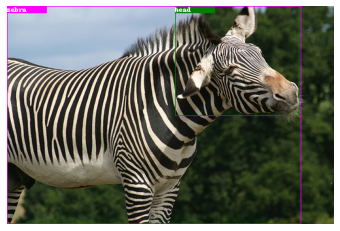

In [78]:
for idx in range(100):
    
    img_path,boxes,labels,gt_rels,pred_rels,pred_rel_score,pred_rel_label= get_info_by_idx(
        idx=idx,det_input=detected_origin_result)
    
    img_name = img_path.split('/')[-1].split('.')[0]  
    
    np_boxes = boxes.cpu().numpy().astype(int)
    
    img = cv2.imread(img_path)

    # You may need to convert the color.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for rel_idx in range(len(gt_rels)):
        
        img_rel_name = gt_path + img_name + '_{}.pdf'.format(str(rel_idx))

        im_pil = Image.fromarray(img)

        subj_idx = int(gt_rels[rel_idx][0].split('-')[0])
        obj_idx = int(gt_rels[rel_idx][2].split('-')[0])

        subj_label = gt_rels[rel_idx][0].split('-')[1]
        obj_label = gt_rels[rel_idx][2].split('-')[1]
        rel_label = gt_rels[rel_idx][1]

        union_box = get_union(np_boxes[subj_idx], np_boxes[obj_idx])

        draw_single_box(im_pil, np_boxes[subj_idx], draw_info=subj_label, color='green')
        draw_single_box(im_pil, np_boxes[obj_idx], draw_info=obj_label, color='magenta')

        gt_triplet = '< ' + subj_label + ', ' + rel_label + ', ' + obj_label + ' >' 
        draw_union_box(im_pil, union_box, draw_info=gt_triplet, color='red')


        print(img_rel_name)
        #display(im_pil)
        
        plt.imshow(im_pil)
        plt.axis('off')
        plt.savefig(img_rel_name, dpi=200)